# About Dataset

The dataset titled "Netflix Stock Price Prediction" is designed for time series analysis and forecasting of Netflix's stock prices. Here are the key details about the dataset:

1. **Dataset Overview:**
   - **Content:** The Dataset contains data for 5 years ie. from 5th Feb 2018 to 5th Feb 2022
   - **Features:** It includes 7 columns:
     - **Date:** Indicates the trading day.
     - **Open:** The opening stock price of Netflix on that day.
     - **High:** The highest price recorded during the trading day.
     - **Low:** The lowest price reached during the day.
     - **Close:** The closing price, adjusted for any stock splits.
     - **Adj Close:** The closing price further adjusted for splits, dividends, and capital gains.
     - **Volume:** The total number of Netflix shares traded on that particular day.

2. **Usage and Relevance:**
   - **Usability:** Rated at 10.00, indicating high usability for business and investment analysis.
   - **Tags:** Tagged with "Business," "Investing," "Intermediate," "Time Series Analysis," "Python," and "LSTM," suggesting its relevance in financial forecasting using Python and LSTM models.
   - **License:** Public Domain (CC0), allowing for unrestricted use and distribution.

3. **Expected Update Frequency:** Never updated, indicating that the dataset covers a fixed time period without ongoing updates.

4. **Data Exploration and Analysis:**
   - The dataset provides insights into Netflix's stock price movements over time, essential for building predictive models and understanding market trends.
   - Ideal for exploring techniques in time series forecasting, such as LSTM (Long Short-Term Memory) models, commonly used for capturing temporal dependencies in sequential data like stock prices.

5. **Additional Information:**
   - **File Size:** 74.93 kB
   - **Downloads:** 16K in the last 30 days, indicating active interest and usage.

This dataset is valuable for researchers, analysts, and data scientists interested in financial forecasting and time series analysis, particularly within the context of stock market prediction using historical data.

## I. Importing Libraries:

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, mean, lag
from pyspark.sql.window import Window

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2. Data Investigation and Preprocessing:

In [36]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("Netflix Stock Price Forecasting") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv("data/NFLX.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)
print(f"Rows: {df.count()}, Columns: {len(df.columns)}")

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)

+----------+----------+----------+----------+----------+----------+--------+
|      Date|      Open|      High|       Low|     Close| Adj Close|  Volume|
+----------+----------+----------+----------+----------+----------+--------+
|2018-02-05|     262.0|267.899994|250.029999|254.259995|254.259995|11896100|
|2018-02-06|247.699997|266.700012|     245.0|265.720001|265.720001|12595800|
|2018-02-07|266.579987|272.450012|264.329987|264.559998|264.559998| 8981500|
|2018-02-08|267.079987|267.619995|     250.0|250.100006|250.100006| 9306700|
|2018-02-09|253.850006|255.800003|236.110001|249.470001|249.470001|16906900|
+----------+----------+----------+----------+----------+----------+--------+
only showing top 5 rows

Rows: 1009, Column

#### Descriptive statistics

In [31]:
df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+-----------------+
|summary|              Open|              High|               Low|             Close|         Adj Close|           Volume|
+-------+------------------+------------------+------------------+------------------+------------------+-----------------+
|  count|              1009|              1009|              1009|              1009|              1009|             1009|
|   mean|419.05967286223984|425.32070308027744|412.37404380178384| 419.0007329207132| 419.0007329207132| 7570685.03468781|
| stddev|108.53753170401458|109.26295957119454|107.55586739006031|108.28999877034995|108.28999877034995|5465535.225689975|
|    min|        233.919998|        250.649994|        231.229996|        233.880005|        233.880005|          1144000|
|    max|        692.349976|         700.98999|        686.090027|        691.690002|        691.690002|         58904300|
+-------+-------

#### Check the missing value and remove missing value

In [ ]:
missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+----+----+----+---+-----+---------+------+
|Date|Open|High|Low|Close|Adj Close|Volume|
+----+----+----+---+-----+---------+------+
|   0|   0|   0|  0|    0|        0|     0|
+----+----+----+---+-----+---------+------+



In [41]:
df = df.dropna()

#### Convert column 'Date' to Timestamp data

In [48]:
df = df.withColumn("Date", col("Date").cast("timestamp"))
# Order time series data
df = df.orderBy("Date")
df.show()

+-------------------+----------+----------+----------+----------+----------+--------+
|               Date|      Open|      High|       Low|     Close| Adj Close|  Volume|
+-------------------+----------+----------+----------+----------+----------+--------+
|2018-02-05 00:00:00|     262.0|267.899994|250.029999|254.259995|254.259995|11896100|
|2018-02-06 00:00:00|247.699997|266.700012|     245.0|265.720001|265.720001|12595800|
|2018-02-07 00:00:00|266.579987|272.450012|264.329987|264.559998|264.559998| 8981500|
|2018-02-08 00:00:00|267.079987|267.619995|     250.0|250.100006|250.100006| 9306700|
|2018-02-09 00:00:00|253.850006|255.800003|236.110001|249.470001|249.470001|16906900|
|2018-02-12 00:00:00|252.139999|259.149994|     249.0|257.950012|257.950012| 8534900|
|2018-02-13 00:00:00|257.290009|261.410004|254.699997|258.269989|258.269989| 6855200|
|2018-02-14 00:00:00|260.470001|269.880005|260.329987|     266.0|     266.0|10972000|
|2018-02-15 00:00:00|270.029999|     280.5|267.630005|

#### Check if there is a stock split or dividend by comparing "Close" with "Adj Close"

In [50]:
df = df.withColumn("Stock_Split", (col("Adj Close") / col("Close")))

#### Calculate price changes based on previous closing prices

In [52]:
window_spec = Window.orderBy("Date")
df = df.withColumn("Prev_Close", lag("Close").over(window_spec))
df = df.withColumn("Price_Change", col("Close") - col("Prev_Close"))
df.show(5)

+-------------------+----------+----------+----------+----------+----------+--------+-----------+----------+-------------------+
|               Date|      Open|      High|       Low|     Close| Adj Close|  Volume|Stock_Split|Prev_Close|       Price_Change|
+-------------------+----------+----------+----------+----------+----------+--------+-----------+----------+-------------------+
|2018-02-05 00:00:00|     262.0|267.899994|250.029999|254.259995|254.259995|11896100|        1.0|      NULL|               NULL|
|2018-02-06 00:00:00|247.699997|266.700012|     245.0|265.720001|265.720001|12595800|        1.0|254.259995| 11.460006000000021|
|2018-02-07 00:00:00|266.579987|272.450012|264.329987|264.559998|264.559998| 8981500|        1.0|265.720001|-1.1600030000000174|
|2018-02-08 00:00:00|267.079987|267.619995|     250.0|250.100006|250.100006| 9306700|        1.0|264.559998|         -14.459992|
|2018-02-09 00:00:00|253.850006|255.800003|236.110001|249.470001|249.470001|16906900|        1.0|

## Exploratory Data Analysis


#### Line Plot display closing prices over time

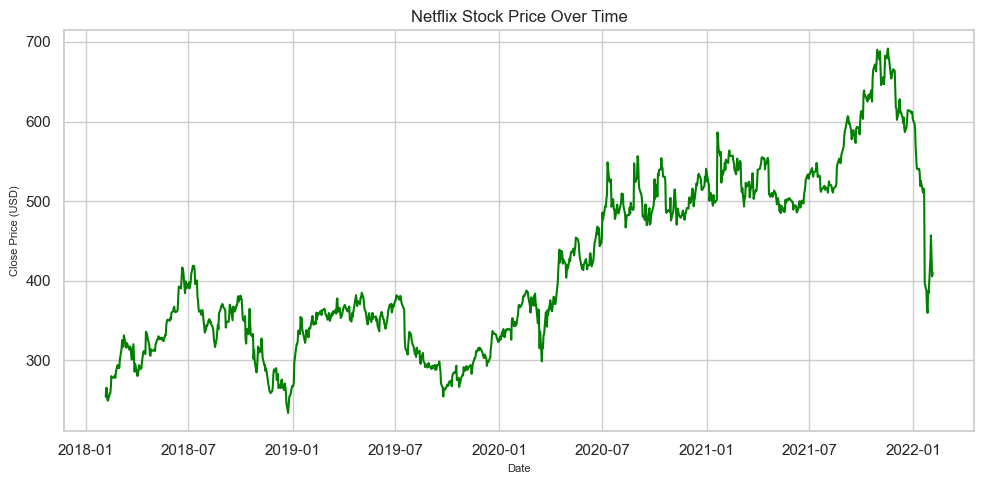

In [79]:
import seaborn as sns
pandas_df = df.toPandas()

plt.figure(figsize=(10, 5))
sns.lineplot(x='Date', y='Close', data=pandas_df, color='green')
plt.title('Netflix Stock Price Over Time', fontsize=12)
plt.xlabel('Date', fontsize=8)
plt.ylabel('Close Price (USD)', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()